# White Blood Cell Detection

We took an unsupervised learning method approach. We were able to find a larger set of images of white blood cells in a Kaggle archive (https://www.kaggle.com/datasets/paultimothymooney/blood-cells). We built a deep learning network using a backbone of Resnet50 pre trained network and trained a variational autoencoder on top of it. At the same time we added a clustering layer.
Implementation of: https://arxiv.org/pdf/1511.06335.pdf but we added a Resnet50 backbone for improved autoencoder and Adadelta optimizer.
This code is an improvement of the following fork: https://github.com/Deepayan137/DeepClustering/blob/master/README.md.

## Cell Types

- Limphocyte: looks like well rounded purple colored potato. These are the easiest to identify.
- Monocyte: The cell shape lookes roundish with skin-red color with some purple stuff inside. However the purple color is never fully covering the cell surface. Also, the purple colored portion of the cell is always in one continuous piece.
- Neutrophil: The cell shape lookes roundish with skin-red color with some purple stuff inside. However the cell contains purple colored multiple whole-groundnuts inside it. The groundnuts could be disjointed within the cell.
- Eosinophil: They look like Neutrophils. Alas! See the confusion matrix published by paultimothymooney. In his kernel, most of the failures happen when predictor falsly thinks that Eosinophils are Neutrophils.
- Mononuclear (Basophil + Lymphocyte vs Monocyte) vs Polynuclear (Neutrophil + Eosinophil).
- Basophils are a type of white blood cell (leukocyte) and are the least common of the granulocytes, representing about 0.5% to 1% of circulating white blood cells. They are part of the immune system and play various roles in both protective and pathological processes. Basophils can be identified under a microscope by their large, dark-staining granules that obscure the cell nucleus. They are typically identified in a blood smear using specific staining techniques. My plan was to use technique like over sampling (SMOTE) in order to complete my dataset, but due to lack of time, I decided to focus only on 4 types of cells. Basophils and eosinophils share the most similarities in terms of visible granules and involvement in allergic and parasitic responses, although each cell type has unique functions within the immune system.

## Distribution of Cell Types

In [7]:
import pandas as pd
import plotly.graph_objs as go


# Load the CSV file into a DataFrame
df = pd.read_csv('./data/labels.csv')

# Split entries containing multiple cell types
split_categories = df['Category'].str.split(',\\s*').explode()

# Count the occurrences of each cell type
category_counts = split_categories.value_counts()

# Create a histogram with multiple colors
histogram = go.Bar(x=category_counts.index,
                   y=category_counts.values,
                   marker=dict(color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple']),
                   width=0.4  # Adjust the width of the bars
                   )

# Layout
layout = go.Layout(title='Distribution of Cell Types',
                   xaxis=dict(title='Cell Type'),
                   yaxis=dict(title='Count'),
                   width=800,  # Set the width of the plot
                   height=500,  # Set the height of the plot
                   )

# Create figure
fig = go.Figure(data=[histogram], layout=layout)

# Show plot
fig.show()

## Data From Kaggle
I found the following repository dataset at Kaggle. Since it doesn't contain Basophil cell types, I decided to oversample Basophile cells. But due to time constraints I didn't complete this task hence I trained the network only on 4 cell types.
Training samples:

- Cell: MONOCYTE         num samples: 2478
- Cell: EOSINOPHIL       num samples: 2497
- Cell: LYMPHOCYTE       num samples: 2483
- Cell: NEUTROPHIL       num samples: 2499

Total training samples: 9957

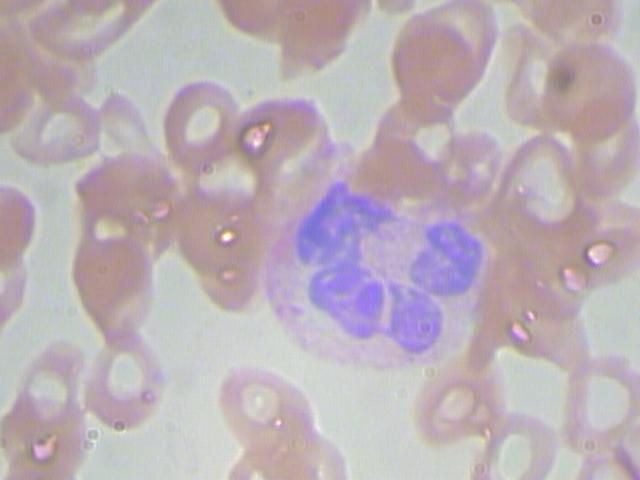

## Preprocessing
Image Resolution: I scaled all my images to 224x224 (px).
For my experimentation, I used 10% of training data as validation set. And yes, the split was stratified.

Image Normalization: I normalized every pixel location over entire training dataset (validation set wasn't used). This way I have a mean and a std. image. For each image in the dataset, I first subtract mean image with it and then I divide it with the std. image.

## Special Accuracy Function For Clustering
This acc function calculates clustering accuracy, which is a measure of how well a clustering algorithm assigns data points to clusters compared to the ground truth labels. It does so by finding the best matching between the predicted cluster assignments (y_pred) and the true labels (y_true), and then calculating the accuracy based on this matching.

Here's how the function works:

1. It first ensures that both y_true and y_pred are integer arrays.
2. It asserts that the sizes of y_true and y_pred are equal.
3. It initializes a confusion matrix w where each entry w[i, j] denotes the number of data points that belong to cluster i according to y_pred and to cluster j according to y_true.
4. It computes the optimal one-to-one matching between the predicted clusters and the true clusters using the Hungarian algorithm, implemented in linear_assignment from scikit-learn.
5. It calculates the accuracy by summing the values of the confusion matrix corresponding to the optimal matching and dividing by the total number of data points.
6. This accuracy measure is specifically tailored for clustering algorithms, where there is no inherent ordering of cluster labels. It accounts for the fact that clusters may be assigned arbitrary labels by the algorithm, and it finds the best matching between these labels and the true labels to compute accuracy.

Traditional accuracy metrics assume a one-to-one correspondence between predicted and true labels, which is not the case in clustering. Instead, the acc function finds the best matching between clusters and true labels, providing a more appropriate measure of clustering performance. We need to find the best matching between the predicted clusters and the true clusters and then evaluate the performance based on this matching. This is what the acc function does by finding the optimal matching using the Hungarian algorithm and computing the accuracy based on this matching.

In [ ]:
import os
import time
import pdb
from tqdm import *
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import Parameter
from torchvision import transforms
from torchvision.utils import save_image
from sklearn.cluster import KMeans
import numpy as np
from tqdm import *
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn.functional as F
import argparse
from scipy.optimize import linear_sum_assignment
import warnings
from PIL import Image
import sys



BATCH_SIZE=32
NUM_CLUSTERS=4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum(w[ind[0], ind[1]]) * 1.0 / y_pred.size

## Network Architecture
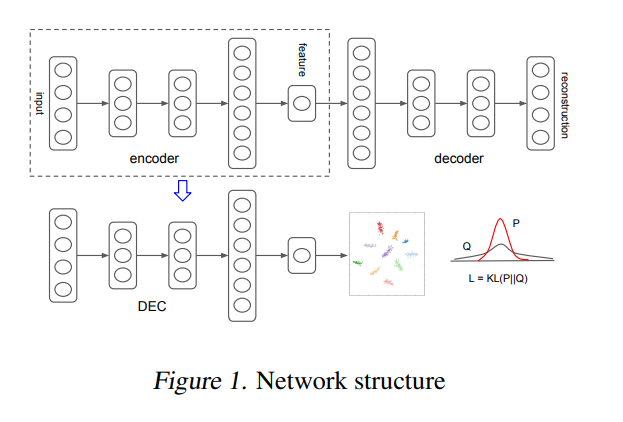

Assuming trainging data is in ./data/train/\<cell type subfolders\>.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, upsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, output_padding=stride-1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.upsample = upsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.upsample:
            residual = self.upsample(x)
        
        # Adjust the size of 'residual' to match 'out' if necessary
        if residual.size() != out.size():
            residual = F.interpolate(residual, size=out.size()[2:], mode='bilinear', align_corners=False)
        
        out += residual
        out = self.relu(out)
        return out

class ResNetAutoEncoder(nn.Module):
    def __init__(self):
        super(ResNetAutoEncoder, self).__init__()
        # Load pretrained ResNet50
        self.resnet = models.resnet50(pretrained=True)
        # Remove the fully connected layer
        modules = list(self.resnet.children())[:-2]
        self.encoder = nn.Sequential(*modules)
        
        # Custom decoder
        self.decoder = nn.Sequential(
            # Starting with the output of ResNet50 that has a feature map size of 7x7
            ResidualBlock(2048, 1024, stride=2, upsample=nn.Sequential(nn.ConvTranspose2d(2048, 1024, kernel_size=1, stride=2, output_padding=1), nn.BatchNorm2d(1024))),
            ResidualBlock(1024, 512, stride=2, upsample=nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size=1, stride=2, output_padding=1), nn.BatchNorm2d(512))),
            ResidualBlock(512, 256, stride=2, upsample=nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=1, stride=2, output_padding=1), nn.BatchNorm2d(256))),
            # Ensuring the output dimensions are exactly matched to the desired size
            ResidualBlock(256, 128, stride=2, upsample=nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=1, stride=2, output_padding=1), nn.BatchNorm2d(128))),
            ResidualBlock(128, 64, stride=2, upsample=nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=1, stride=2, output_padding=1), nn.BatchNorm2d(64))),
            # Final layer to adjust to 3 channels, considering the target size is 224, which might need a final adjustment
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Changed to Tanh assuming input images are normalized [-1,1]; change to Sigmoid if [0,1]
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # Adjust the final output size to [224, 224] explicitly
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x

class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters=NUM_CLUSTERS, hidden=10, cluster_centers=None, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.hidden = hidden
        if cluster_centers is None:
                initial_cluster_centers = torch.zeros(
                self.n_clusters,
                self.hidden,
                dtype=torch.float
                ).cuda()
                nn.init.xavier_uniform_(initial_cluster_centers)
        else:
          initial_cluster_centers = cluster_centers
        self.cluster_centers = Parameter(initial_cluster_centers)

    def forward(self, x):
        #print("x shape after unsqueeze:", x.unsqueeze(1).shape) #torch.Size([32, 1, 2048, 7, 7])
        #print("cluster_centers shape:", self.cluster_centers.shape) #torch.Size([4, 100352]) 100352=2048*7*7
        total_features = x.size(1) * x.size(2) * x.size(3)  # Adjusted to consider actual dimensions of x
        x = x.view(-1, total_features)  # Reshape x to [batch_size, feature_vector_length]
        norm_squared = torch.sum((x.unsqueeze(1) - self.cluster_centers)**2, 2)
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2
        numerator = numerator**power
        t_dist = (numerator.t() / torch.sum(numerator, 1)).t() #soft assignment using t-distribution
        return t_dist

class DEC(nn.Module):
    def __init__(self, n_clusters=NUM_CLUSTERS, autoencoder=None, hidden=10, cluster_centers=None, alpha=1.0):
        super(DEC, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.hidden = hidden
        self.cluster_centers = cluster_centers
        self.autoencoder = autoencoder
        self.clusteringlayer = ClusteringLayer(self.n_clusters, self.hidden, self.cluster_centers, self.alpha)

    def target_distribution(self, q_):
        weight = (q_ ** 2) / torch.sum(q_, 0)
        return (weight.t() / torch.sum(weight, 1)).t()

    def forward(self, x):
        x = self.autoencoder.encode(x) 
        y = self.clusteringlayer(x)
        return y


    def visualize(self, epoch,x):
        fig = plt.figure()
        ax = plt.subplot(111)
        x = self.autoencoder.encode(x).detach() 
        x = x.cpu().numpy()
        # Reshape x from (32, 2048, 7, 7) to (32, 2048*7*7) to flatten the feature maps
        x = x.reshape(x.shape[0], -1)  # This changes x to have a shape of (32, 2048*7*7)
        x_embedded = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(x)
        plt.scatter(x_embedded[:,0], x_embedded[:,1])
        fig.savefig(f'plots/data_{epoch}.png')
        plt.close(fig)

def add_noise(img):
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        return noisy_img

def save_checkpoint(state, filename, is_best):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print(time.ctime(), "=> Saving new checkpoint")
        torch.save(state, filename)
    else:
        print(time.ctime(), "=> Validation Accuracy did not improve")

def pretrain(**kwargs):
        train_loader = kwargs['data']
        model = kwargs['model']
        num_epochs = kwargs['num_epochs']
        savepath = kwargs['savepath']
        checkpoint = kwargs['checkpoint']
        start_epoch = checkpoint['epoch']
        parameters = list(autoencoder.parameters())
        optimizer = torch.optim.Adam(parameters, lr=1e-3, weight_decay=1e-5)
        for epoch in range(start_epoch, num_epochs):
          for data in train_loader:
              #data[0] is batch of images. data[1] is batch of labels.
              img  = data[0]
              noisy_img = add_noise(img)
              noisy_img = noisy_img.to(device)
              img = img.to(device)
              # ===================forward=====================
              output = model(noisy_img)
              #output = output.squeeze(1)
              #output = output.view(output.size(0), 28*28)
              loss = nn.MSELoss()(output, img)
              # ===================backward====================
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          # ===================log========================
          print('epoch [{}/{}], MSE_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
          state = loss.item()
          is_best = False
          if state < checkpoint['best']:
              checkpoint['best'] = state
              is_best = True

          save_checkpoint({'state_dict':model.state_dict(), 'best':state, 'epoch':epoch}, savepath, is_best)


def train(**kwargs):
        train_loader = kwargs['data']
        model = kwargs['model']
        num_epochs = kwargs['num_epochs']
        savepath = kwargs['savepath']
        checkpoint = kwargs['checkpoint']
        start_epoch = checkpoint['epoch']
        features = []
        labels = np.array([])

        for batch in tqdm(train_loader):
            img = batch[0]
            img = img.to(device)
            batch_labels = batch[1]
            batch_labels = batch_labels.detach().cpu().numpy()
            labels = np.append(labels, batch_labels)
            batch_features = model.autoencoder.encode(img).detach().cpu()
            #Flatten the features for each image in the batch.
            batch_features_flattened = batch_features.view(batch_features.size(0), -1)
            features.append(batch_features_flattened)
        #Concatenate all features into a single tensor and then convert it to a 2D numpy array.
        features = torch.cat(features, 0).numpy()

        # ============K-means=======================================
        kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(features)
        cluster_centers = kmeans.cluster_centers_
        cluster_centers = torch.tensor(cluster_centers, dtype=torch.float).cuda()
        model.clusteringlayer.cluster_centers = torch.nn.Parameter(cluster_centers)
        # =========================================================
        y_pred = kmeans.predict(features)
        accuracy = acc(labels, y_pred)
        print(time.ctime(), 'Initial Accuracy: {}'.format(accuracy))

        loss_function = nn.KLDivLoss(size_average=False)
        optimizer = torch.optim.Adadelta(params=model.parameters(), lr=0.1)#, momentum=0.9)
        print(time.ctime(), 'Training')
        row = []
        imgs = None
        
        for epoch in range(start_epoch, num_epochs):
          for batch in tqdm(train_loader):
                imgs = batch[0]
                imgs = imgs.to(device)
                batch_labels = batch[1]
                batch_labels = batch_labels.detach().cpu().numpy()
                output = model(imgs)
                target = model.target_distribution(output).detach()
                out = output.argmax(1)
                loss = loss_function(output.log(), target) / output.shape[0]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                accuracy = acc(batch_labels, out.cpu().numpy())
                row.append([epoch, accuracy])
                print('Epochs: [{}/{}] Accuracy:{}, Loss:{}'.format(epoch, num_epochs, accuracy, loss))
                state = loss.item()
                is_best = False
                if state < checkpoint['best']:
                    checkpoint['best'] = state
                    is_best = True
                save_checkpoint({'state_dict':model.state_dict(), 'best':state, 'epoch':epoch}, savepath, is_best)
          print(time.ctime(), f'epoch {epoch}, plotting')
          dec.visualize(epoch, imgs)

        df = pd.DataFrame(row, columns=['epochs', 'accuracy'])
        df.to_csv('log.csv')

 
def load_data():
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the images to a common size
        #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if your model expects 1 channel input
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images for each channel
    ])
    
    # Load the dataset from folders
    train_dataset = ImageFolder(root=DATA_DIR, transform=transform)
    #test_dataset = ImageFolder(root='./data/test/', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    #test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader

def get_cluster_assignment(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move to device
    with torch.no_grad():
        output = model(image)
        cluster_id = output.argmax(dim=1).item()  # Assuming output shape is [1, n_clusters]
    return cluster_id

if __name__ == '__main__':
        parser = argparse.ArgumentParser(description='train',
                                         formatter_class=argparse.ArgumentDefaultsHelpFormatter)

        parser.add_argument('--batch_size', default=BATCH_SIZE, type=int)
        parser.add_argument('--pretrain_epochs', default=1, type=int)
        parser.add_argument('--train_epochs', default=100, type=int)
        parser.add_argument('--save_dir', default='saves')
        parser.add_argument('--predict', type=str, help='Path to the image for prediction.')
        args = parser.parse_args()
        print(time.ctime(), args)
        epochs_pre = args.pretrain_epochs
        batch_size = args.batch_size

        x = load_data()
        autoencoder = ResNetAutoEncoder().to(device)
        ae_save_path = 'saves/sim_autoencoder.pth'

        if os.path.isfile(ae_save_path):
                print(time.ctime(), 'Loading {}'.format(ae_save_path))
                checkpoint = torch.load(ae_save_path)
                autoencoder.load_state_dict(checkpoint['state_dict'])
        else:
                print(time.ctime(), "=> no checkpoint found at '{}'".format(ae_save_path))
                checkpoint = {"epoch":0, "best": float("inf")}
        pretrain(data=x, model=autoencoder, num_epochs=epochs_pre, savepath=ae_save_path, checkpoint=checkpoint)
        
        dec_save_path='saves/dec.pth'
        dec = DEC(n_clusters=NUM_CLUSTERS, autoencoder=autoencoder, hidden=100352, cluster_centers=None, alpha=1.0).to(device)
        
        if os.path.isfile(dec_save_path):
                print(time.ctime(), 'Loading {}'.format(dec_save_path))
                checkpoint = torch.load(dec_save_path)
                dec.load_state_dict(checkpoint['state_dict'])
        else:
                print(time.ctime(), "=> no checkpoint found at '{}'".format(dec_save_path))
        
        if args.predict:
          transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
          cluster_id = get_cluster_assignment(args.predict, dec, transform)
          print(f"Cluster assignment for input image {args.predict}: {cluster_id}")

          # Loop through each sub-folder (cell type) in the training data directory
          for cell_type in os.listdir(DATA_DIR):
              cell_type_path = os.path.join(DATA_DIR, cell_type)
              if os.path.isdir(cell_type_path):
                  # Get the first image from the sub-folder
                  image_name = os.listdir(cell_type_path)[0]
                  image_path = os.path.join(cell_type_path, image_name)             
                  # Get cluster assignment for the current cell type's image
                  cluster_id = get_cluster_assignment(image_path, dec, transform)                 
                  # Print or process the cluster assignment as needed
                  print(f"Cluster assignment for {cell_type} (image: {image_name}): {cluster_id}")
          sys.exit(0)
        
        checkpoint = {"epoch":0, "best": float("inf")}
        train(data=x, model=dec, num_epochs=args.train_epochs, savepath=dec_save_path, checkpoint=checkpoint)

## Results After 10 Epochs of Pretraining And 100 Epochs of Training
In some epochs we can see a significant improvement. Only the best models are kept.
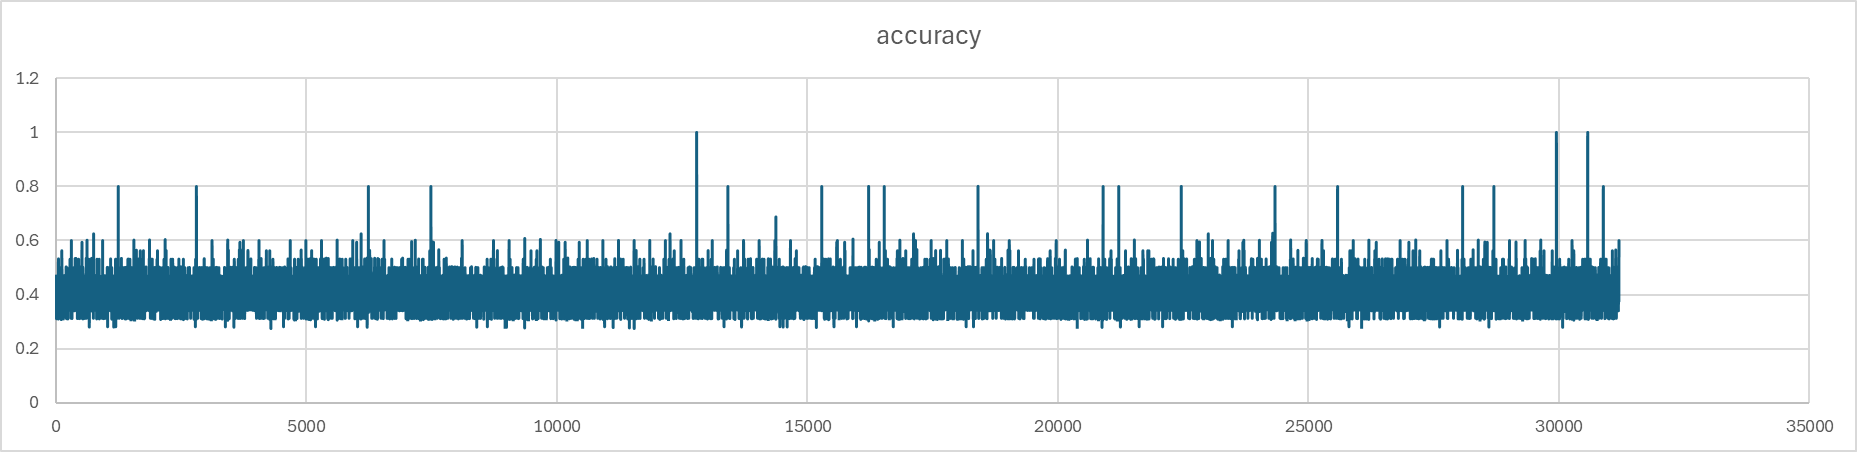

## New Patient
Handle patient 100 using predict and clustering assignment reveal a Monocyte cell type.

### References
https://www.kaggle.com/datasets/paultimothymooney/blood-cells/code

https://www.kaggle.com/code/paultimothymooney/identify-blood-cell-subtypes-from-images

https://www.kaggle.com/code/placidpanda/deep-learning-from-scratch-insights

https://www.kaggle.com/code/tanlikesmath/white-blood-cell-classification-with-fastai

https://github.com/KeremTurgutlu/self_supervised

https://www.kaggle.com/code/tathagatbanerjee/blood-cell-detection-100-acc-transfer-learning

https://www.kaggle.com/code/balakrishcodes/yolo-v5-blood-cell-detection-and-count

https://github.com/facebookresearch/deepcluster

https://github.com/facebookresearch/swav/blob/main/main_deepclusterv2.py

https://arxiv.org/pdf/1511.06335.pdf

https://github.com/szagoruyko/pytorchviz